In [2]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/COMP-6721")

Mounted at /content/drive


In [3]:
"""
Preparing the pickle
"""
from pathlib import Path

import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
from tqdm import tqdm
from pathlib import Path
import shutil


dirpath = Path('data/dataset')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
os.makedirs('data/dataset')
datasetPath = Path('data/dataset/dataset.zip')
gdd.download_file_from_google_drive(file_id='1hlCHe-lCQO-Sr8oB5NOnsWXd4Q-htC7E',
                                    dest_path=str(datasetPath),
                                    unzip=True)
# delete zip file
datasetPath.unlink()

datasetPath = Path('data/dataset')
maskPath = datasetPath/'with_mask'
nonMaskPath = datasetPath/'without_mask'
randomPath = datasetPath/'random'
maskDF = pd.DataFrame()

for imgPath in tqdm(list(maskPath.iterdir()), desc='with_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='without_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

for imgPath in tqdm(list(randomPath.iterdir()), desc='random_images'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

dfName = 'data/dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

Unzipping...

with_mask:   0%|          | 0/3725 [00:00<?, ?it/s]

Done.


random_images: 100%|██████████| 3726/3726 [00:13<00:00, 271.49it/s]

Saving Dataframe to: data/dataset/dataset.pickle


In [38]:
"""
The DataSet class
"""
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Normalize


class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = Compose([
            Resize((100, 100)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [23]:
"""
The CNN model
"""
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential, functional)

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(50, 25, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(25 * 25 * 25, 100)
        self.fc2 = nn.Linear(100, 3)
    
    def forward(self, x: Tensor):
        """ forward pass
        """
        out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 25 * 25 * 25)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

face_mask_detector_cnn = FaceMaskDetectorCNN()

In [24]:
"""
Some utilities
"""
from pathlib import Path
from typing import Dict, List, Union

import pandas as pd
import torch
import torch.nn.init as init
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        train, validate = train_test_split(mask_df, test_size=0.3, random_state=0,
                                           stratify=mask_df['mask'])
        return [
            MaskDetectionDataset(train),
            MaskDetectionDataset(validate),
            CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=4)

train_df, validate_df, cross_entropy_loss = prepare_data("data/dataset/dataset.pickle")

In [26]:
"""
Training Step
"""

LEARNING_RATE = 0.001

def train_model():
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=LEARNING_RATE)
    for epoch in range(10):
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_df), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss
        print("Training Loss:", loss_train)

train_model()
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(86.0971, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(68.9544, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(66.0189, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(60.8558, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(62.8300, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(58.5200, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(62.6606, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(57.8815, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(65.1386, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training Loss: tensor(59.7137, grad_fn=<AddBackward0>)
Finished Training


In [37]:
"""
Evaluate the model
"""
from numpy import vstack

def evaluate_model():
    predictions, actuals = np.array([]), np.array([])
    for i, data in enumerate(val_dataloader(validate_df)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = np.append(predictions,output.numpy())
        actuals = np.append(actuals,targets.numpy())
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc
print(evaluate_model())

0.8646572104018913


data/dataset/without_mask/without_mask_807.jpg
Actual: without_mask
Predicted: without_mask


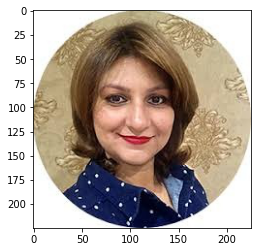

In [93]:
"""
Predict
"""

import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "with_mask",
    2: "not_a_person"
}

def predict():
  rand_sampler = torch.utils.data.RandomSampler(validate_df, num_samples=32, replacement=True)
  data = iter(DataLoader(validate_df, batch_size=32, num_workers=1, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  print(data['path'][rand_ind])
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()